# Suprema Simulation


## Pip Install

In [ ]:
!pip uninstall pyblm --yes
!cd blm_tmp; pip install .
!cd /well/nichols/users/inf852/suprema_sims_repo 


In [ ]:
!pip install dask
!pip install crtoolbox
!pip install numpy
!pip install matplotlib
!pip install distributed

## Imports

In [1]:
# blm imports
from blm.blm_cluster import _main as blm
import yaml

# Dask imports
from dask.distributed import Client, as_completed
from dask_jobqueue import SLURMCluster

# Basic imports
import os
import sys
import shutil
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import time

# Import supporting functions
from crtoolbox.lib.boundary import *
from crtoolbox.lib.display import *
from crtoolbox.lib.regression import *

# Import bootstrap functions
from crtoolbox.bootstrap import *

# Import data generation
from crtoolbox.tests.generate_2d_data import *

## Setup

In [2]:
# Set output directory
out_dir = '/well/nichols/users/inf852/sup_sim'

# If output directory does not exist, create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Hausdorff Function

In [3]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def hausdorff(A, B):
    """
    Compute the Hausdorff distance between two binary images.
    
    Parameters:
        - A, B: n-dimensional numpy arrays.
    
    Returns:
        - Hausdorff distance.
    """
    
    # Get the coordinates of non-zero pixels
    coords_A = np.array(np.where(A)).T
    coords_B = np.array(np.where(B)).T
    
    # If one of the images has no non-zero pixels, the Hausdorff distance is infinite
    if coords_A.shape[0] == 0 or coords_B.shape[0] == 0:
        return float('inf')

    # Hausdorff distance is the maximum of the directed distances
    return max(directed_hausdorff(coords_A, coords_B)[0], directed_hausdorff(coords_B, coords_A)[0])

# Example
image1 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [1, 0, 0]
])

image2 = np.array([
    [0, 1, 0],
    [0, 0, 0],
    [1, 0, 0]
])

print(hausdorff(image1, image2))  # Should print the Hausdorff distance between the two images


2.23606797749979


## Ground Truth Analysis

Set up ground truth analysis.

In [4]:
# Ground truth directory
gt_dir = os.path.join(out_dir, 'ground_truth')

# Threshold c=1% BOLD signal change
c = 10

# If ground truth directory does not exist, create it
if not os.path.exists(gt_dir):
    os.makedirs(gt_dir)

# Construct the inputs.yaml for the ground truth analysis with the following parameters:
inputs = {
    "MAXMEM": '2**34',
    "M_files": "/users/nichols/inf852/Biobank1_Mfiles_2021.txt",
    "OutputCovB": 0,
    "X": "/users/nichols/inf852/Biobank1_X_2021.csv",
    "Y_files": "/users/nichols/inf852/Biobank1_Yfiles_2021.txt",
    "analysis_mask": "/well/win/software/packages/fsl/5.0.11/data/standard/MNI152_T1_2mm_brain_mask.nii.gz",
    "contrasts": [
        {
            "c1": {
                "name": "Tcontrast1",
                "vector": [1,0,0,0,0,0]
            }
        }
    ],
    "outdir": gt_dir,
    "sim": 1,
    "numNodes": 100,
    "clusterType": "SLURM",
}

# Write the inputs.yaml file
with open(os.path.join(gt_dir, 'inputs.yml'), 'w') as outfile:
    yaml.dump(inputs, outfile, default_flow_style=False)



In [5]:
# # Mask files
# M_files = "/users/nichols/inf852/Biobank1_Mfiles_2021.txt"

# # Construct the M list file by taking the lines corresponding to the selected subject indices
# with open(M_files) as f:
#     lines = f.readlines()

# # Make the files into a list
# M_files = []
# for i in np.arange(len(lines)):
#     M_files.append(lines[i].strip())

# # Get number of images
# n_subs = len(M_files)

# print(n_subs)
    
# # Loop through images to create analysis mask
# for i in range(0, n_subs):
    
#     print(i)

#     # Read in image
#     img = read_image(M_files[i])


#     # Check if we are on the first image
#     if i == 0:

#         # Initialize mask
#         mask = 1*(img > 0.9)

#     # Update mask
#     mask = mask*(1*(img > 0.9))
    

# # Write beta coefficient to file
# addBlockToNifti(os.path.join(gt_dir,"mask.nii"), 
#                 mask, np.arange(np.prod(mask.shape)), 
#                 volInd=0,dim=mask.shape)

# display_volume(mask)

mask_gt = os.path.join(gt_dir,"mask.nii")

Run BLM analysis

In [6]:
t1 = time.time()

# Run the ground truth analysis
#blm([os.path.join(gt_dir, 'inputs.yml')])

# The analysis should now be complete. We can now define the ground truth mu
#beta_file = os.path.join(gt_dir, 'blm_vox_beta.nii')

# Load the mu file
#mu = nib.load(beta_file).get_fdata()

# Make sure the mu file is 3D by removing any singleton dimensions
#mu = mu[:, :, :, 0]

# Create mu file
mu_file = os.path.join(out_dir, 'mu.nii')

# Sahttp://localhost:8889/notebooks/Suprema_Simulationn_HCP.ipynb#ve the mu file back to blm_vox_beta.nii
#nib.save(nib.Nifti1Image(mu, np.eye(4)), mu_file)

t2 = time.time()
print(t2-t1)

4.9591064453125e-05


In [ ]:
# Make a view of mu
display_volume(mu_file, mode='axial')

## Regression Function

In [8]:
import os
import numpy as np
import nibabel as nib
from crtoolbox.lib.fileio import read_image
from crtoolbox.tests.generate_ni_data import addBlockToNifti

"""
Read images from a list of filenames in chunks and perform
regression on each chunk. The regression is performed using
the following equation:

    y = X * beta + epsilon

where y is the image, X is the design matrix, beta is the 
regression coefficients, and epsilon is the error. The
regression coefficients are computed using the following
equation:

    beta = (X'X)^-1 X'y

where X' is the transpose of X and ^-1 is the inverse.

Parameters:
-----------
yfiles : list
    list of filenames for the images to be regressed
X : array
    design matrix
out_dir : str
    directory to save the regression results
chunk_size : int
    number of images to read in at a time

Returns:
--------
files : list
    list of filenames for the regression results. The filenames
    are in the order of: beta, sigma, and epsilon.
"""
def regression2(yfiles, mfiles, X, out_dir, chunk_size=20):

    # Get number of images
    n_imgs = len(yfiles)

    # Get number of rows in design matrix
    n = X.shape[0]

    # Check if n_imgs matches number of rows in design matrix
    if n_imgs != n:
            
        # Raise error
        raise ValueError("Number of images does not match number of rows in design matrix")

    # Get number of columns in design matrix
    p = X.shape[1]
    
    # Read in a single image to get image size
    img = read_image(yfiles[0])
    
    # Get image size
    img_size = img.shape

    # Get the dimension of the image
    D = len(img_size)

    # Loop through images to create a running mask
    for i in range(0, n_imgs):

        # Read in image
        img = read_image(mfiles[i])
        

        # Check if we are on the first image
        if i == 0:

            # Initialize mask
            mask = 1*(img > 0.9)

        # Update mask
        mask = mask*(1*(img > 0.9))
    
    # Read in images in chunks
    for i in range(0, n_imgs, chunk_size):

        # Get end index
        end = min(i + chunk_size, n_imgs)

        # Get number of images in chunk
        n_chunk = end - i

        # Initialize arrays
        y_chunk = np.zeros(img_size + (n_chunk, 1))
        X_chunk = np.zeros(tuple((1 for i in range(D))) + (n_chunk, p))

        # Loop through images in chunk        
        for j in range(0, n_chunk):

            # Read in image
            img = read_image(yfiles[i + j])

            # Apply mask
            img = img*mask

            # Add image to array
            y_chunk[..., j, 0] = img

            # Add design matrix to array
            X_chunk[..., j, :] = X[i + j, :]

        # Compute X'X for chunk
        XtX_chunk = X_chunk.swapaxes(-1,-2) @ X_chunk

        # Compute X'y for chunk
        Xty_chunk = X_chunk.swapaxes(-1,-2) @ y_chunk

        # Compute y'y for chunk
        yty_chunk = y_chunk.swapaxes(-1,-2) @ y_chunk

        # Add X'X, X'y and y'y for chunk to total
        if i == 0:

            # Initialize arrays
            XtX = np.zeros(XtX_chunk.shape)
            Xty = np.zeros(Xty_chunk.shape)
            yty = np.zeros(yty_chunk.shape)

        # Add to total
        XtX = XtX + XtX_chunk
        Xty = Xty + Xty_chunk
        yty = yty + yty_chunk

    # Compute beta
    beta = np.linalg.pinv(XtX) @ Xty

    # Compute sum of squared errors
    ete = yty - beta.swapaxes(-1,-2) @ Xty

    # Compute sigma
    sigma = np.sqrt(ete / n)

    # Empty stores for filenames
    beta_files = []
    resid_files = []
    sigma_file = []

    # If the image is 3D then output nifti image
    if D == 3:

        # Write sigma to file
        addBlockToNifti(os.path.join(out_dir,"sigma.nii"), sigma,
                        np.arange(np.prod(img_size)), volInd=0,dim=img_size)
        
        # Add filename to list
        sigma_file = os.path.join(out_dir,"sigma.nii")

    # Otherwise output as a numpy array
    else:

        # Write sigma to file
        np.save(os.path.join(out_dir,"sigma.npy"), sigma)

        # Add filename to list
        sigma_file = os.path.join(out_dir,"sigma.npy")

    # Loop through beta coefficients
    for i in range(0, p):

        # If the image is 3D then output nifti image
        if D == 3:

            # Write beta coefficient to file
            addBlockToNifti(os.path.join(out_dir,"betahat"+str(i)+".nii"), 
                            beta[..., i, 0], np.arange(np.prod(img_size)), 
                            volInd=0,dim=img_size)
            
            # Add filenames to list
            beta_files.append(os.path.join(out_dir,"betahat"+str(i)+".nii"))
            
        # Otherwise output as a numpy array
        else:

            # Write beta coefficient to file
            np.save(os.path.join(out_dir,"betahat"+str(i)+".npy"), beta[..., i, 0])

            # Add filenames to list
            beta_files.append(os.path.join(out_dir,"betahat"+str(i)+".npy"))

    # Write beta coefficient to file
    addBlockToNifti(os.path.join(out_dir,"mask.nii"), 
                    mask, np.arange(np.prod(img_size)), 
                    volInd=0,dim=img_size)

    # Add filenames to list
    mask_file = os.path.join(out_dir,"mask.nii")
#     # Loop through images creating residuals
#     for i in range(0, n_imgs):

#         # Read in image
#         img = read_image(yfiles[i])

#         # Compute residuals
#         res = (img - (X[..., i:(i+1), :] @ beta)[..., 0, 0])

#         # If the image is 3D then output nifti image
#         if D == 3:

#             # Write residuals to file
#             addBlockToNifti(os.path.join(out_dir,"res"+str(i)+".nii"), 
#                             res, np.arange(np.prod(img_size)), 
#                             volInd=0,dim=img_size)
            
#             # Add filenames to list
#             resid_files.append(os.path.join(out_dir,"res"+str(i)+".nii"))

#         # Otherwise output as a numpy array
#         else:

#             # Write residuals to file
#             np.save(os.path.join(out_dir,"res"+str(i)+".npy"), res)

#             # Add filenames to list
#             resid_files.append(os.path.join(out_dir,"res"+str(i)+".npy"))

    # Check if there is only one beta file 
    if len(beta_files) == 1:

        # Change beta_files to a string
        beta_files = beta_files[0]
        
    # Return filenames
    return beta_files, sigma_file, mask_file#, resid_files  
        
    

## Set up HCP


In [9]:
def get_results(Y_files, M_files, X_file, mask_gt, mu_file, c, n_sub, out_dir, sim_ind):
    
    # Set the output directory for this simulation instance
    sim_dir = os.path.join(out_dir, 'sim_{:04d}'.format(sim_ind) + '_n' + str(n_sub))

    # If the output directory does not exist, create it
    if not os.path.exists(sim_dir): 
        os.makedirs(sim_dir)
    
    # Randomly select n_sub subject indices between 0 and 2021
    sub_idx = np.random.choice(4922, n_sub, replace=False)
    
    # Construct the Y list file by taking the lines corresponding to the selected subject indices
    with open(Y_files) as f:
        lines = f.readlines()
    
    # Make the files into a list
    Y_files = []
    for idx in sub_idx:
        Y_files.append(lines[idx].strip())
    
    # Construct the M list file by taking the lines corresponding to the selected subject indices
    with open(M_files) as f:
        lines = f.readlines()
    
    # Make the files into a list
    M_files = []
    for idx in sub_idx:
        M_files.append(lines[idx].strip())
        
    # Construct the X file by taking the lines corresponding to the selected subject indices
    X = pd.read_csv(X_file, header=None)
    X = X.iloc[sub_idx, :].values
    
    # Fit the regression model
    betahat_files, sigma_file, mask_file = regression2(Y_files, M_files, X, sim_dir)
    muhat_file = betahat_files[0]
    
    # Load in mu file
    mu = nib.load(mu_file).get_fdata()

    # Load in muhat file
    muhat = nib.load(muhat_file).get_fdata().reshape(mu.shape)
    
    # Compute mask
    mask = (muhat!=0) & (mu!=0)
    mask_gt = nib.load(mask_gt).get_fdata().reshape(mu.shape)
    
    # Apply mask to both muhat and mu
    mu = mu*mask*mask_gt
    muhat = muhat*mask*mask_gt

    # Work out the suprema of their absolute difference
    sup_diff = np.max(np.abs(muhat - mu))

    # Work out Ac
    Ac = mu > c

    # Work out AcHat
    AcHat = muhat > c

    # Get boundary map for Ac
    Ac_bdry = get_bdry_map_combined(Ac,mask=mask)

    # Get boundary map for AcHat
    AcHat_bdry = get_bdry_map_combined(AcHat,mask=mask)

    # Work out Hausdorff distance between muhat and mu
    haus_dist = hausdorff(Ac_bdry, AcHat_bdry)

    # Add results to results csv in out_dir
    results_file = os.path.join(out_dir, 'new_results_' + 'n' + str(n_sub) + '.csv')

    # File lock
    lock_file = results_file + '.lock'

    # Wait until lock file is removed
    while os.path.exists(lock_file):
        pass

    # Create lock file
    with open(lock_file, 'w') as f:
        pass

    # If results file does not exist, create it
    if not os.path.exists(results_file):
        with open(results_file, 'w') as f:
            f.write('sup_diff,haus_dist\n')

    # Append results to results file
    with open(results_file, 'a') as f:
        f.write('{},{}\n'.format(sup_diff, haus_dist))

    # Remove lock file
    os.remove(lock_file)
    
    # Remove sim directory
    shutil.rmtree(sim_dir)
    
X_file = "/users/nichols/inf852/Biobank1_X_2021.csv"
Y_files = "/users/nichols/inf852/Biobank1_Yfiles_2021.txt"
M_files = "/users/nichols/inf852/Biobank1_Mfiles_2021.txt"
sim_ind = 39
n_sub = 400
c = 10

t1 = time.time()
get_results(Y_files, M_files, X_file, mask_gt, mu_file, c, n_sub, out_dir, sim_ind)
t2 = time.time()

ValueError: Error: Image cannot be loaded in

In [ ]:
print(t2-t1)

In [10]:
mask_file = "/well/nichols/users/inf852/sup_sim/sim_0039_n400/mask.nii"
mask = nib.load(mask_file).get_fdata()

display_volume(mask)

FileNotFoundError: No such file or no access: '/well/nichols/users/inf852/sup_sim/sim_0039_n400/mask.nii'

In [ ]:
muhat_file = "/well/nichols/users/inf852/sup_sim/sim_0039_n400/betahat0.nii"
muhat = nib.load(muhat_file).get_fdata()

display_volume(muhat> 100)

In [ ]:
mu_file = "/well/nichols/users/inf852/sup_sim/mu.nii"
mu = nib.load(mu_file).get_fdata()

display_volume(mu > 100)

In [ ]:
Ac = mu > c
AcHat = muhat.reshape(mu.shape) > c

display_volume(1*AcHat-1*Ac)

## Cluster Submission


Simulation variables for running on the cluster.

In [72]:
# Setup for running on cluster
n_sim = 1001

# Number of nodes
n_node = 100

# Number of sims per node
n_sim_per_node = n_sim//n_node

# Range of subject values
n_subs = np.arange(10,80,10)

print(n_subs)

[10 20 30 40 50 60 70]


In [73]:
# Load the SLURM Cluster
cluster = SLURMCluster()

# --------------------------------------------------------------------------------
# Connect to client
# --------------------------------------------------------------------------------

# Connect to cluster
client = Client(cluster)   


# Ask for 100 nodes for computation
cluster.scale(n_node)

/users/nichols/inf852/miniconda3/lib/python3.9/site-packages/distributed/node.py:182: UserWarning:

Port 46405 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33650 instead



In [74]:
# Empty futures list
futures = []

# Loop through subjects
for n_sub in n_subs:

    # Submit jobs
    for sim_ind in np.arange(n_sim):

        # Run the jobNum^{th} job.run_simulation(n_sim, n, out_dir, 5000)
        future_b = client.submit(get_results, Y_files, M_files, X_file, mask_gt, mu_file, c, n_sub, out_dir, sim_ind, pure=False)

        # Append to list 
        futures.append(future_b)

# Completed jobs
completed = as_completed(futures)

# Wait for results
for i in completed:
    i.result()

# Delete the future objects (NOTE: see above comment in setup section).
del i, completed, futures, future_b

FileNotFoundError: [Errno 2] No such file or directory: '/well/nichols/users/inf852/sup_sim/new_results_n10.csv.lock'

In [71]:
# Close the client
client.close()
client.shutdown()

In [ ]:
!pip show crtoolbox | grep Location


In [ ]:
import crtoolbox
print(crtoolbox.__path__)

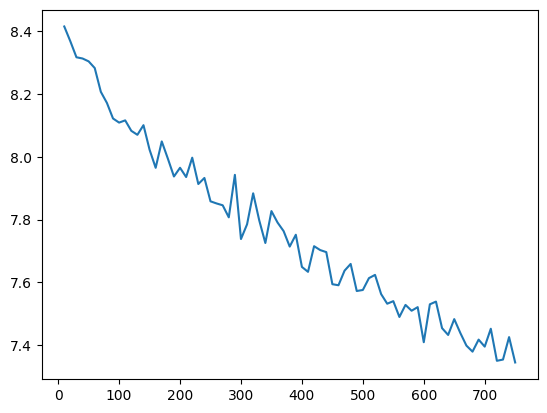

In [79]:
import glob

# Get a list of files of the form new_results_n*.csv
results_files = glob.glob(os.path.join(out_dir, 'new_results_n*.csv'))

# For each file, get the number of subjects represented by the filename
n_sub_list = [int(f.split('_n')[1].strip('.csv')) for f in results_files]

# Loop through sample sizes and compute the mean of the suprema and Hausdorff distances
sup_diff_mean = []
haus_dist_mean = []

for n_sub in n_sub_list:

    # Get the results file for this sample size
    results_file = os.path.join(out_dir, 'new_results_n' + str(n_sub) + '.csv')

    # Read in the results file
    results = pd.read_csv(results_file)

    # Compute the mean of the suprema and Hausdorff distances
    sup_diff_mean.append(results['sup_diff'].mean())
    haus_dist_mean.append(results['haus_dist'].mean())

# Sort the sample sizes and mean suprema and Hausdorff distances
n_sub_list, sup_diff_mean, haus_dist_mean = zip(*sorted(zip(n_sub_list, sup_diff_mean, haus_dist_mean)))

# Plot the mean suprema and Hausdorff distances against sample size
#plt.plot(n_sub_list, sup_diff_mean, label='Suprema')
plt.plot(n_sub_list, haus_dist_mean, label='Hausdorff')


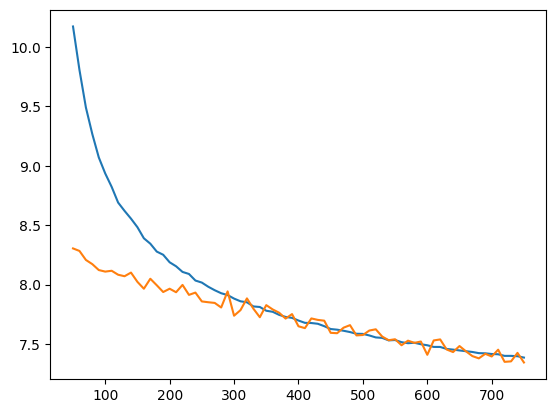

In [89]:

# Construct design matrix containing an intercept and the suprema
X = np.vstack((np.ones(len(n_sub_list)), np.array(sup_diff_mean))).T

haus_dist_mean = np.array(haus_dist_mean)
haus_dist_mean = haus_dist_mean.reshape((haus_dist_mean.shape[0],1))

n_sub_list = np.array(n_sub_list).reshape(haus_dist_mean.shape)

# Fit linear model
beta = np.linalg.pinv(X[30:,:].T @ X[30:,:]) @ X[30:,:].T @ np.array(haus_dist_mean)[30:,:]

# Make predicted line for hausdorff distance
haus_dist_pred = X @ beta

# Plot the mean suprema and Hausdorff distances against sample size
plt.plot(n_sub_list[4:,:], haus_dist_pred[4:,:], label='Predicted')
plt.plot(n_sub_list[4:,:], haus_dist_mean[4:,:], label='Hausdorff')

In [57]:
print(1/beta[1,0])

202.52456026784606


In [53]:
int(results_files[0].split('_n')[1].strip('.csv'))

630